# Assignment 1 : Spam Email Detection Using Naive Bayesian

## Importing Libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer

## Dataset Preprocessing

### Loading the dataset

In [21]:
data_directory=r'G:\My Drive\Phd Courses\CS 5841- Machine Learning\Assignments\1\spam_ham_dataset.csv'
df = pd.read_csv(data_directory)
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


### Handling Missing Values

In [22]:
# Quick overview of how many missing values are in each column
print("Missing values in each column:")
print(df.isnull().sum())

# Get the size of the imported data
imported_data_size = df.shape
print("\nImported data size:", imported_data_size)

### important point: this code was developed because df.fillna(mean_values, inplace=True) which is a common technique, did not simply work for text 


# Recognizing problematic data
problematic_data = []
for i in range(imported_data_size[0]):
    for j in range(imported_data_size[1]): 
        if pd.isnull(df.iloc[i, j]):
            print("There are some NaN values in imported data")
            problematic_data.append([i, j])

# Cleaning problematic data: modification if possible 
for i in range(len(problematic_data)):
    temp_data = problematic_data[i]

    # Replace NaN in the first column with the mean value of the column
    if temp_data[1] == 0:  # specifying number of words in email column
        print("yes")
        df.iloc[:, 0] = pd.to_numeric(df.iloc[:, 0], errors='coerce')
        mean_value = df.iloc[:, 0].mean(skipna=True)
        df.iloc[temp_data[0], 0] = mean_value
        
    # If email text or label is missing, remove the row
    else:
        df.drop(temp_data[0], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)


Missing values in each column:
Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

Imported data size: (5171, 4)


### Text preprocessing

In [30]:
# initial definition of features and labels

X = df['text']
y = df['label_num']

# importing Natural Language Toolkit to use its text cleaning capabilities such as removal of stopping words

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# converting to lower case 
X=X.astype(str)
print(X.dtype)
X=X.apply(lambda x: x.lower())

# Define stop words
stop_words = set(stopwords.words('english'))

cleaned_texts = []

for text in X:
    
    # Step 1: Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Step 2: Tokenize text
    words = word_tokenize(text)
    
    # Step 3: Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Step 4: Join cleaned words back into a single string
    cleaned_text = ' '.join(filtered_words)
    

    cleaned_texts.append(cleaned_text)


# Attach these new columns to the DataFrame
df["cleaned_text"]   = cleaned_texts

print(df.head())


vectorizer = CountVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(df['cleaned_text'])

# Before balancing
print("Before balancing:")
print(y.value_counts())

# Use RandomOverSampler to balance the dataset
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=123)
X_balanced, y_balanced = ros.fit_resample(X, y)

# After balancing
print("\nAfter balancing:")
print(y_balanced.value_counts())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\majidr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\majidr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\majidr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


object
   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num                                       cleaned_text  
0          0  subject enron methanol meter 988291 follow not...  
1          0  subject hpl nom january 9 2001 see attached fi...  
2          0  subject neon retreat ho ho ho around wonderful...  
3          1  subject photoshop windows office cheap main tr...  
4          0  subject indian springs deal book teco pvr reve...  
Before balancing:
label_num
0    3672
1    1499
Name: count, dtype: int64

After balancing:
label_num
0    3672
1    3672
Name: count, dtype: int64


## Modeling

### Train test split

In [24]:
# spliting data to training and testing; *80% train and 20% test; "random_state=42" ensures consistant random selection thorough multiple runds

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


### Multinomial Naive Bayes

In [25]:
model = MultinomialNB()

model.fit(X_train, y_train)

### Predictions

y_pred_mnb = model.predict(X_test)

### Gaussian Naive Bayes

In [26]:
model = GaussianNB()

# Convert X_train and X_test to dense arrays
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

model.fit(X_train_dense, y_train)

y_pred_gnb = model.predict(X_test_dense)


## Evaluation

### Accuracy

In [27]:
accuracy_mnb = np.round(accuracy_score(y_test, y_pred_mnb),3)
accuracy_gnb = np.round(accuracy_score(y_test, y_pred_gnb),3)

print(f"Accuracy of Multinomial Naive Bayes (Percent): {accuracy_mnb*100} %")
print(f"Accuracy of Gaussian Naive Bayes (Percent): {accuracy_gnb*100} %")

Accuracy of Multinomial Naive Bayes (Percent): 97.8 %
Accuracy of Gaussian Naive Bayes (Percent): 96.5 %


### Confusion Matrix

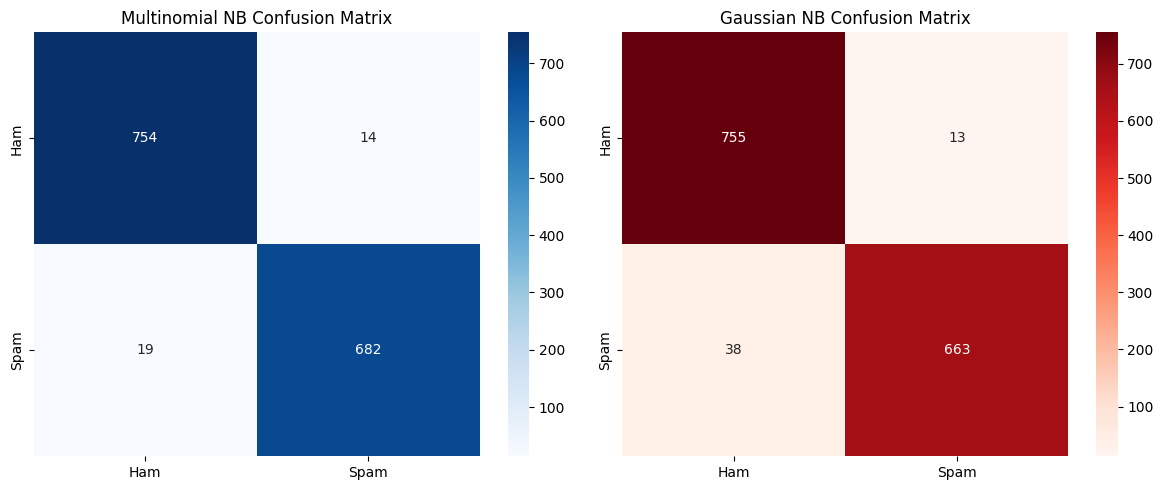

In [28]:
conf_matrix_mnb = confusion_matrix(y_test, y_pred_mnb)
conf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb)

# Add heatmap visualization for confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_mnb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Multinomial NB Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_gnb, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Gaussian NB Confusion Matrix')
plt.tight_layout()
plt.show()

### Precision, Recall, F1 Score

In [29]:
precision_mnb, recall_mnb, f1_mnb, _ = precision_recall_fscore_support(y_test, y_pred_mnb, average='binary')
precision_gnb, recall_gnb, f1_gnb, _ = precision_recall_fscore_support(y_test, y_pred_gnb, average='binary')


print(f"Precision of Multinomial Naive Bayes: {np.round(precision_mnb,3)*100}%")
print(f"Recall of Multinomial Naive Bayes: {np.round(recall_mnb,3)*100}%")
print(f"F1 Score of Multinomial Naive Bayes: {np.round(f1_mnb,3)*100}%")
print(f"Precision of Gaussian Naive Bayes: {np.round(precision_gnb,3)*100}%")
print(f"Recall of Gaussian Naive Bayes: {np.round(recall_gnb,3)*100}%")
print(f"F1 Score of Gaussian Naive Bayes: {np.round(f1_gnb,2)*100}%")

Precision of Multinomial Naive Bayes: 98.0%
Recall of Multinomial Naive Bayes: 97.3%
F1 Score of Multinomial Naive Bayes: 97.6%
Precision of Gaussian Naive Bayes: 98.1%
Recall of Gaussian Naive Bayes: 94.6%
F1 Score of Gaussian Naive Bayes: 96.0%


### ROC Curve

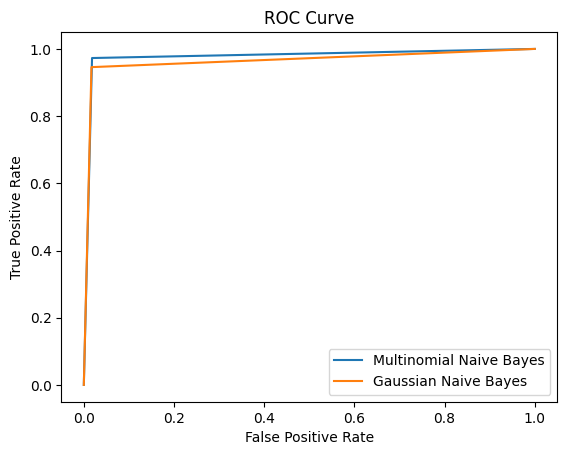

In [19]:
from sklearn.metrics import roc_curve, auc

fpr_mnb, tpr_mnb, _ = roc_curve(y_test, y_pred_mnb)
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_pred_gnb)

roc_auc_mnb = auc(fpr_mnb, tpr_mnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

sns.lineplot(x=fpr_mnb, y=tpr_mnb, label='Multinomial Naive Bayes')
sns.lineplot(x=fpr_gnb, y=tpr_gnb, label='Gaussian Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()